### Sample code to create a decision tree and visualize the tree structure
Dave Snell for DSCI 408 and 508, Maryville University

In [3]:
import pandas as pd
import os  
import numpy as np
from sklearn import tree
from IPython.display import Image

In [4]:
folder = os.getcwd() + '/'  # double backslashes for Windows OS

In [5]:
df = pd.read_csv(folder + 'animals-training.csv', header=0)
df

,Legs,Body Covering,Animal
0,0,scales,snake
1,0,scales,snake
2,2,feathers,bird
3,2,feathers,bird
4,2,feathers,bird
5,2,furry,gorilla
6,2,furry,gorilla
7,4,furry,dog
8,4,furry,dog
9,4,furry,dog


In [27]:
def calc_gini(df, split_selector):
    sel = df.loc[:, 'Legs'] <= 3
    true_node = df.loc[sel, :]
    true_node.head()

In [7]:
calc_gini (df, None)

In [28]:
sel = df.loc[:, 'Legs'] <= 3
true_node = df.loc[sel, :]
false_node = df.loc[~ sel, :]
true_node.head()

,Legs,Body Covering,Animal
0,0,scales,snake
1,0,scales,snake
2,2,feathers,bird
3,2,feathers,bird
4,2,feathers,bird


In [36]:
true_node_grouped = true_node.groupby('Animal').size().reset_index(name='counts')
true_node_size = len(true_node)
true_node_grouped.loc[:,'p'] = true_node_grouped.loc[:,'counts'] / true_node_size
true_node_grouped.loc[:,'pnot'] = 1 - true_node_grouped.loc[:,'p'] 
true_node_grouped.loc[:,'logp'] = np.log2(true_node_grouped.loc[:,'p'])
true_node_grouped.loc[:,'Entropy'] = true_node_grouped.loc[:,'p'] * -1 * true_node_grouped.loc[:,'logp']
true_node_grouped.loc[:,'Gini'] = true_node_grouped.loc[:,'p'] * true_node_grouped.loc[:,'pnot']
true_node_grouped.head()

,Animal,counts,p,pnot,logp,Entropy,Gini
0,bird,3,0.428571,0.571429,-1.222392,0.523882,0.244898
1,gorilla,2,0.285714,0.714286,-1.807355,0.516387,0.204082
2,snake,2,0.285714,0.714286,-1.807355,0.516387,0.204082


In [19]:
true_node.shape

(13, 3)

In [42]:
def calc_node_gini_entropy(node_df):
    """
        Group the node dataframe by Animal, and add columns for Gini and Entropy
    """
    node_size = len(node_df)
    # Group by Animal column
    node_df_grouped = node_df.groupby('Animal').size().reset_index(name='counts')
    # Intermediate columns
    node_df_grouped.loc[:,'p'] = node_df_grouped.loc[:,'counts'] / node_size
    node_df_grouped.loc[:,'pnot'] = 1 - node_df_grouped.loc[:,'p'] 
    node_df_grouped.loc[:,'logp'] = np.log2(node_df_grouped.loc[:,'p'])
    # Entropy
    node_df_grouped.loc[:,'Entropy'] = node_df_grouped.loc[:,'p'] * -1 * node_df_grouped.loc[:,'logp']
    # Gini
    node_df_grouped.loc[:,'Gini'] = node_df_grouped.loc[:,'p'] * node_df_grouped.loc[:,'pnot']
    # return result
    return node_df_grouped

In [43]:
true_node_grouped = calc_node_gini_entropy(true_node)
true_node_grouped.head()

,Animal,counts,p,pnot,logp,Entropy,Gini
0,bird,3,0.428571,0.571429,-1.222392,0.523882,0.244898
1,gorilla,2,0.285714,0.714286,-1.807355,0.516387,0.204082
2,snake,2,0.285714,0.714286,-1.807355,0.516387,0.204082


In [44]:
animals = len(df)
print (animals)

20


In [45]:
false_node_grouped = calc_node_gini_entropy(false_node)
false_node_grouped.head()

,Animal,counts,p,pnot,logp,Entropy,Gini
0,butterfly,7,0.538462,0.461538,-0.893085,0.480892,0.248521
1,caterpillar,2,0.153846,0.846154,-2.700440,0.415452,0.130178
2,cow,1,0.076923,0.923077,-3.700440,0.284649,0.071006
3,dog,3,0.230769,0.769231,-2.115477,0.488187,0.177515


In [46]:
false_node_grouped['counts'].sum()

np.int64(13)

In [47]:
entropy = (len(true_node) * true_node_grouped['Entropy'].sum() + len(false_node) * false_node_grouped['Entropy'].sum()) / animals
print (entropy)

1.6297970665753632


In [48]:
gini = (len(true_node) * true_node_grouped['Gini'].sum() + len(false_node) * false_node_grouped['Gini'].sum()) / animals
print (gini)

0.6362637362637362


<Axes: >

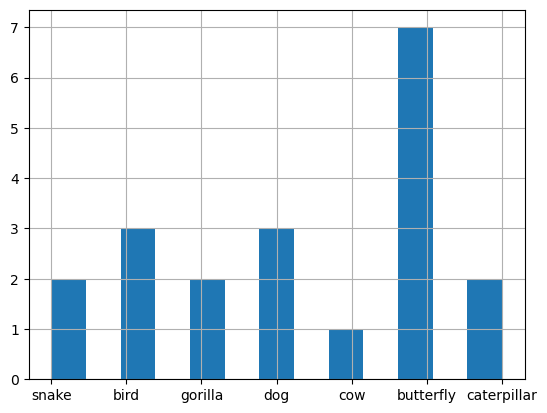

In [5]:
df['Animal'].hist(bins=13)

<Axes: >

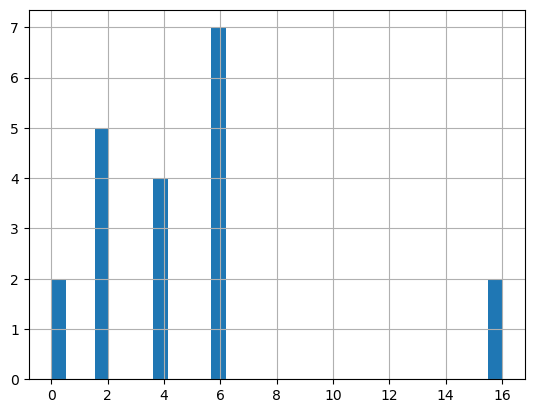

In [5]:
df['Legs'].hist(bins=31)

<Axes: >

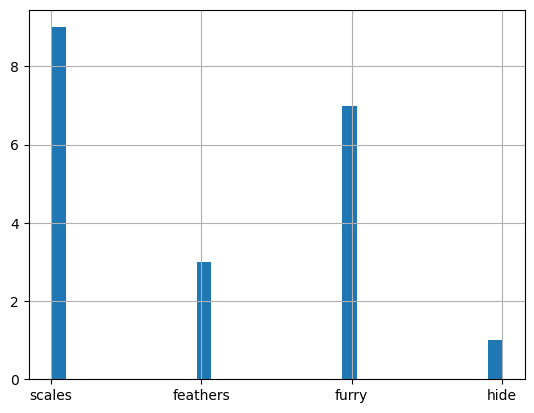

In [6]:
df['Body Covering'].hist(bins=31)

### The tree classifier from scikit-learn expects all numbers so convert the categorical items to dummy variables

In [6]:
col_list = list( df.columns)
objList = []
for col in col_list:
    if df.dtypes[col] == object:
        objList.append(col)
objList # this is our list of categorical variables

['Body Covering', 'Animal']

In [7]:
# turn all object types into dummy variables 1-Hot style
df_cats = pd.get_dummies(df[objList[:-1]], prefix_sep='_', drop_first=False) # 1-hot, not triangular
df_cats.head()

,Body Covering_feathers,Body Covering_furry,Body Covering_hide,Body Covering_scales
0,False,False,False,True
1,False,False,False,True
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False


In [8]:
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Legs,0,0,2,2,2,2,2,4,4,4,4,6,6,6,6,6,6,6,16,16
Body Covering,scales,scales,feathers,feathers,feathers,furry,furry,furry,furry,furry,hide,scales,scales,scales,scales,scales,scales,scales,furry,furry
Animal,snake,snake,bird,bird,bird,gorilla,gorilla,dog,dog,dog,cow,butterfly,butterfly,butterfly,butterfly,butterfly,butterfly,butterfly,caterpillar,caterpillar


In [9]:
numList = [item for item in col_list if item not in objList] # this is our list of numeric variables

In [10]:
df_nums = df[numList]

In [11]:
df_vars = pd.concat([df_nums, df_cats],axis=1)
X = df_vars

In [12]:
df_vars.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Legs,0,0,2,2,2,2,2,4,4,4,4,6,6,6,6,6,6,6,16,16
Body Covering_feathers,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Body Covering_furry,False,False,False,False,False,True,True,True,True,True,False,False,False,False,False,False,False,False,True,True
Body Covering_hide,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
Body Covering_scales,True,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,False,False


In [13]:
features = list( df_vars.columns)
features

['Legs',
 'Body Covering_feathers',
 'Body Covering_furry',
 'Body Covering_hide',
 'Body Covering_scales']

In [14]:
y = df.iloc[:, -1].values    # take all rows and only the last column

In [15]:
# We are now ready to train our Decision Tree classifier
clf=tree.DecisionTreeClassifier(max_leaf_nodes=None, criterion='gini') # gini is actually the default method
clf=clf.fit(X,y)

In [16]:
predictions = clf.predict(X)
accuracy = (predictions == y).sum() / len(predictions)
accuracy

np.float64(1.0)

## Now that we have created the decision tree, we will use graphviz to let us see the tree.

In [17]:
picName = 'animals-gini'

In [18]:
with open(folder + picName + '.dot','w') as f:
    # f=tree.export_text(clf,feature_names=features,outfile=f) # we could just output the rules - no fun!
    f = tree.export_graphviz(clf, feature_names=features,out_file=f)

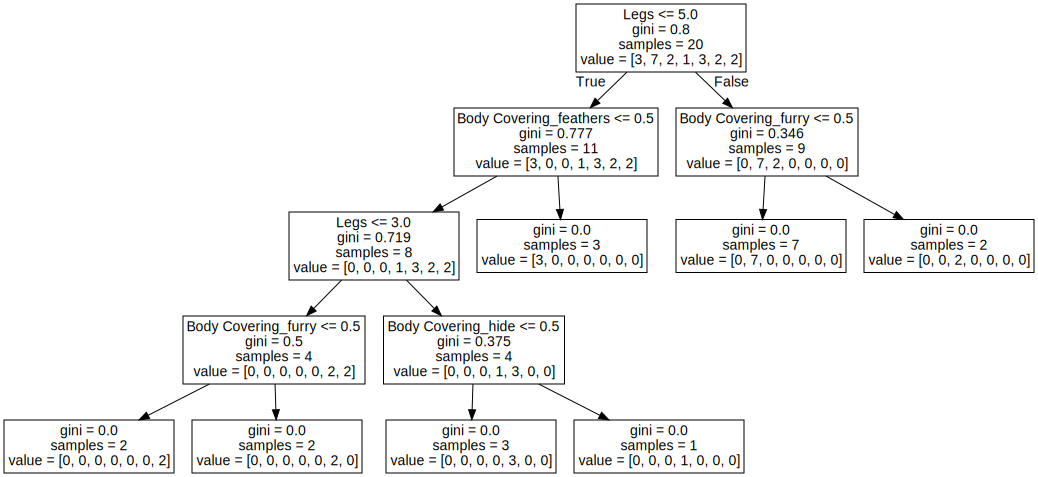

In [19]:
import graphviz
from graphviz import Digraph

with open(folder + picName + '.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## The next two cells are optional. I prefer to see my tree graph without scrolling so I have to convert it into a .png file.

In [20]:
def showTreeAsPNG(folder, picName):
    # My general philosopy is the Hippocratic 'first do no harm'
    cwd = os.getcwd() + '\\'                   # so I will first get the current working directory of the command
    os.chdir(folder)                           # prompt and later restore it.
    # Convert dot to png via graphviz           
    dotFile = folder + picName + '.dot'        # I will build a command line that I want to execute.   
    pngFile = folder + picName + '.png'        # Then, I'll run that batch file 
    command = 'dot -Tpng "' + dotFile  +  '" -o "' + pngFile + '"'
    f= open(folder + "tempCmd.bat","w")        # I put that command into a .bat (batch) file in the folder 
    f.write(command)                           # that contains my file to be converted. This avoids problems if the
    f.close()                                  # folder name contains spaces.
    # The following line executes the batch file.
    !tempCmd.bat 
    os.chdir(cwd)                              # When done, I reset the current working directory as it was.

In [21]:
showTreeAsPNG(folder, picName)
Image(filename=folder+picName + '.png')    # Now, we get to see the entire tree without scrolling!

/bin/bash: tempCmd.bat: command not found


FileNotFoundError: [Errno 2] No such file or directory: '/Users/matt/Dev/Maryville/DSCI-508/Notebooks\\'

## Now, let's repeat the tree generation, but using the entropy method

In [22]:
clf=tree.DecisionTreeClassifier(criterion='entropy')
clf=clf.fit(X,y)

In [23]:
predictions = clf.predict(X)
accuracy = (predictions == y).sum() / len(predictions)
accuracy

np.float64(1.0)

In [27]:
picName = 'animals-entropy'

In [24]:
with open(folder + picName + '.dot','w') as f:
    f = tree.export_graphviz(clf, feature_names=features,out_file=f)

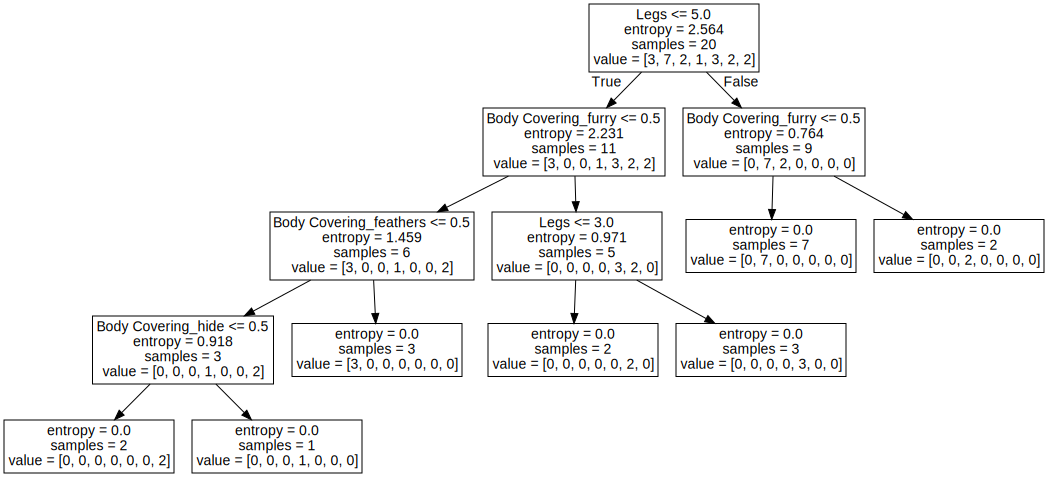

In [25]:
with open(folder + picName + '.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


(charts) C:\Users\Dave\Dropbox\Maryville\2020\Online\Week6 - Visualizations and Presentation Skills\DSCI408-508\Week5-staging>dot -Tpng "C:\Users\Dave\Dropbox\Maryville\2020\Online\Week6 - Visualizations and Presentation Skills\DSCI408-508\Week5-staging\animals-entropy.dot" -o "C:\Users\Dave\Dropbox\Maryville\2020\Online\Week6 - Visualizations and Presentation Skills\DSCI408-508\Week5-staging\animals-entropy.png" 


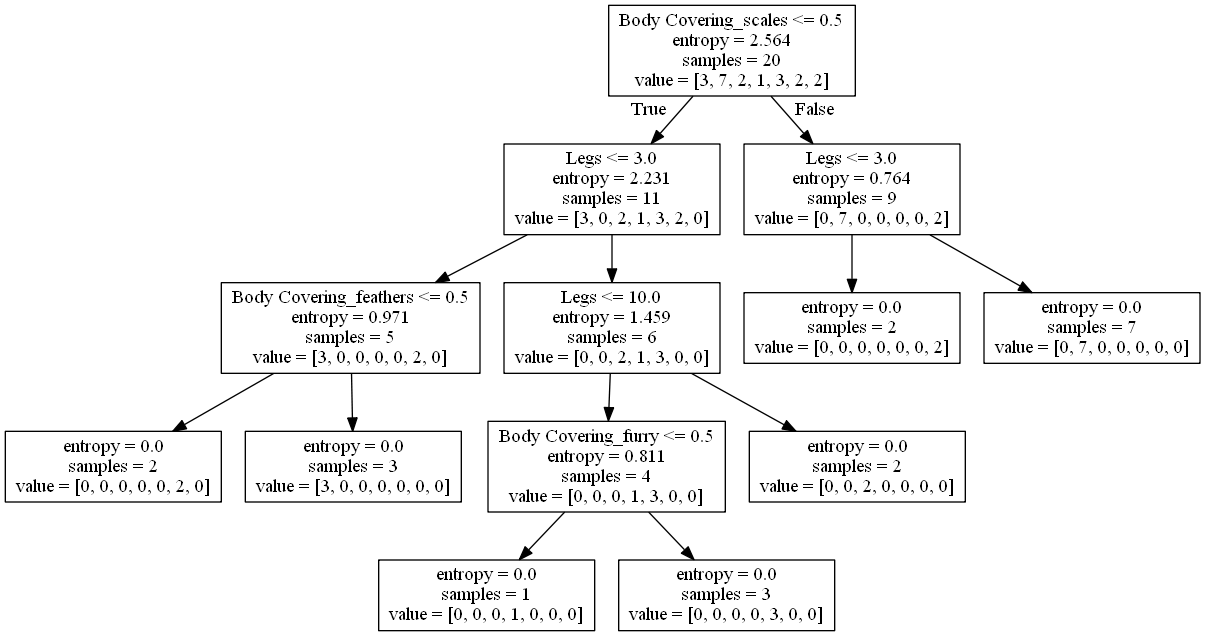

In [30]:
showTreeAsPNG(folder, picName)
Image(filename=folder+picName + '.png') 

## ASSIGNMENT for DSCI 408
### create a training set with a different mixof these animals, say 5 of each type. Run your new training set through this code and generate a new tree. See how the Gini and entropy values change in this new tree.

## ASSIGNMENT for DSCI 508
### create a decision tree to classify a group of vehicles:
* a sedan, a convertible, a motorcycle, a long-haul truck
* use features of number of wheels and type of roof (soft/hard/none)
* modify this code to create the decision tree